<a href="https://colab.research.google.com/github/juniajeff/AI_training/blob/main/predicting_users_mark_most_similar_movies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 9.0 MB/s 
     |████████████████████████████████| 5.3 MB 56.5 MB/s 
     |████████████████████████████████| 1.3 MB 44.9 MB/s 
     |████████████████████████████████| 441 kB 57.8 MB/s 
     |████████████████████████████████| 1.6 MB 53.6 MB/s 
     |████████████████████████████████| 115 kB 61.5 MB/s 
     |████████████████████████████████| 163 kB 61.8 MB/s 
     |████████████████████████████████| 212 kB 55.0 MB/s 
     |████████████████████████████████| 127 kB 62.6 MB/s 
     |████████████████████████████████| 115 kB 32.5 MB/s 
     |████████████████████████████████| 7.6 MB 41.9 MB/s 
Mounted at /content/gdrive


Collaborative Filtering Deep Dive

A First Look at the Data

In [ ]:
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)
# MovieLens: millions of movie rankings (a combination of a movie ID, a user ID, and a numeric rating)
# we will just use a subset of 100,000 of them for our example.

In [ ]:
path

Path('/root/.fastai/data/ml-100k')

In [ ]:
! cp -r /root/.fastai/data/ml-100k /content/sample_data/

In [ ]:
# the main table is in the file u.data. It is tab-separated and the columns are, respectively user, movie, rating, and timestamp. 
# Since those names are not encoded, we need to indicate them when reading the file with Pandas.
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])

In [ ]:
type(ratings)

pandas.core.frame.DataFrame

In [ ]:
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
# capturing characteristics of a movie using a set numbers varing from -1 to 1
# for example, using three numbers, we can see whether a movie is science-fiction, action, and old
# we are scoring very science-fiction as 0.98, very action as 0.9, and very not old as -0.9.
last_skywalker = np.array([0.98,0.9,-0.9])

In [ ]:
# We could represent a user who likes modern sci-fi action movies as
user1 = np.array([0.9,0.8,-0.6])

In [ ]:
type(user1)

numpy.ndarray

In [ ]:
# dot product
(user1*last_skywalker).sum()

2.1420000000000003

In [ ]:
0.98*0.9+0.9*0.8+(-0.9)*(-0.6)

2.1420000000000003

In [ ]:
casablanca = np.array([-0.99,-0.3,0.8])

In [ ]:
(user1*casablanca).sum()

-1.611

Merging data

In [ ]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [ ]:
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


Creating the DataLoaders

In [ ]:
# We can then build a DataLoaders object from this table.
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,542,My Left Foot (1989),4
1,422,Event Horizon (1997),3
2,311,"African Queen, The (1951)",4
3,595,Face/Off (1997),4
4,617,Evil Dead II (1987),1
5,158,Jurassic Park (1993),5
6,836,Chasing Amy (1997),3
7,474,Emma (1996),3
8,466,Jackie Chan's First Strike (1996),3
9,554,Scream (1996),3


In [ ]:
dls.classes

{'user': ['#na#', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 

In [ ]:
n_users  = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

n_users, n_movies

(944, 1665)

In [ ]:
user_factors = torch.randn(n_users, n_factors) # user latent facor matrix, or user embeddings
user_factors, user_factors.shape

(tensor([[-1.0827,  0.2138,  0.9310, -0.2739, -0.4359],
         [-0.5195,  0.7613, -0.4365,  0.1365,  1.3300],
         [-1.2804,  0.0705,  0.6489, -1.2110,  1.8266],
         ...,
         [ 0.8009, -0.4734, -0.8962, -0.7348, -0.0246],
         [ 0.3354, -0.8262, -0.1541,  0.4699,  0.4873],
         [ 2.4054, -0.2156, -1.4126, -0.2467,  1.0571]]), torch.Size([944, 5]))

In [ ]:
movie_factors = torch.randn(n_movies, n_factors) # movie latent facor matrix, or movie embeddings
movie_factors, movie_factors.shape

(tensor([[-0.3978,  0.4563,  1.2301,  0.3745,  0.9689],
         [-1.1836, -0.5818, -0.5587, -0.4316,  0.2128],
         [ 0.0420,  1.3201, -0.7999,  1.1123, -0.7585],
         ...,
         [ 2.4743,  1.3068,  0.4540,  0.6958,  0.5228],
         [ 2.3970, -0.2559, -1.7196,  1.0440, -0.2662],
         [ 0.2786, -0.6593,  0.5260, -0.3416, -1.3938]]),
 torch.Size([1665, 5]))

In [ ]:
user_factors[0,:]

tensor([-1.0827,  0.2138,  0.9310, -0.2739, -0.4359])

In [ ]:
movie_factors[0,:]

tensor([-0.3978,  0.4563,  1.2301,  0.3745,  0.9689])

In [ ]:
emb = Embedding(n_movies,5)
emb(tensor(range(n_movies)))

tensor([[ 0.0054, -0.0015, -0.0018,  0.0131, -0.0159],
        [-0.0188, -0.0026,  0.0104, -0.0134, -0.0028],
        [-0.0015, -0.0050,  0.0161, -0.0045,  0.0071],
        ...,
        [-0.0133,  0.0033, -0.0187, -0.0174,  0.0087],
        [-0.0040, -0.0124,  0.0129,  0.0133,  0.0048],
        [ 0.0094,  0.0017, -0.0050, -0.0087,  0.0093]], grad_fn=<EmbeddingBackward0>)

Collaborative Filtering from Scratch

In [ ]:
# We can use existing class to define new one
# Creating DotProduct class. using PyTorch class, Module
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors): # embedding layers were used to represent latent factors for user and movie
        self.user_factors = Embedding(n_users, n_factors) # embedding layers were used to represent latent factors for user and movie
        self.movie_factors = Embedding(n_movies, n_factors)
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users * movies).sum(dim=1)
# Note that the input of the model is a tensor of shape batch_size x 2
# The first column (x[:, 0]) contains the user IDs and the second column (x[:, 1]) contains the movie IDs. 

In [ ]:
x,y = dls.one_batch()
x.shape, y.shape

(torch.Size([64, 2]), torch.Size([64, 1]))

In [ ]:
x[0,:]

tensor([661, 659])

In [ ]:
n_users, n_movies

(944, 1665)

In [ ]:
model = DotProduct(n_users, n_movies, 50) # n_users = 944, n_movies = 1665, n_factors = 50
learn = Learner(dls, model, loss_func=MSELossFlat())

In [ ]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.344918,1.280799,00:08
1,1.102677,1.117535,00:08
2,0.964828,0.995257,00:09
3,0.817083,0.897093,00:09
4,0.780941,0.884064,00:08


In [ ]:
# Making this model better by forcing those predictions to be between 0 and 5
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [ ]:
doc(sigmoid_range)

sigmoid_range(x, low, high)
Sigmoid function with range `(low, high)`

To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev


In [ ]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.976857,0.993766,00:08
1,0.870785,0.912907,00:09
2,0.672737,0.874454,00:08
3,0.480500,0.879083,00:10
4,0.378543,0.882832,00:08


In [ ]:
# Updating our model
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1]) # adding bias
        return sigmoid_range(res, *self.y_range)

In [ ]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)
# we can see the validation loss stopped improving in the middle and started to get worse. 
# As we've seen, this is a clear indication of overfitting.

epoch,train_loss,valid_loss,time
0,0.934955,0.948506,00:09
1,0.843130,0.865363,00:10
2,0.595881,0.863485,00:09
3,0.409885,0.884409,00:09
4,0.287919,0.891908,00:09


Weight Decay

In [ ]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.929033,0.958336,00:09
1,0.887864,0.881745,00:09
2,0.769688,0.833837,00:09
3,0.596804,0.823647,00:09
4,0.505892,0.823814,00:09


In [ ]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

In [ ]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [ ]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.928116,0.951890,00:08
1,0.870317,0.883452,00:10
2,0.729802,0.841948,00:10
3,0.591372,0.830288,00:10
4,0.483222,0.830069,00:09


Interpreting Embeddings and Biases

In [ ]:
# movies with the lowest values in the bias vector:
movie_bias = learn.model.movie_bias.squeeze()
movie_factors = learn.model.movie_factors.squeeze()

In [ ]:
type(movie_bias)

torch.Tensor

In [ ]:
movie_bias.shape, movie_factors.shape

(torch.Size([1665]), torch.Size([1665, 50]))

In [ ]:
movie_bias[:5]

tensor([-3.5224e-04, -1.0367e-01,  9.9417e-03, -2.8427e-02,  3.9355e-01], grad_fn=<SliceBackward0>)

In [ ]:
movie_bias.sort()[:5]
# even when movies are matched well with users, they are still not liked by users.

(tensor([-0.3185, -0.3159, -0.3152,  ...,  0.5621,  0.5934,  0.5936], grad_fn=<SortBackward0>),
 tensor([ 295,  850, 1251,  ..., 1330, 1318, 1501]))

In [ ]:
movie_bias.argsort()[:5]

tensor([ 295,  850, 1251, 1001,  784])

In [ ]:
idxs = movie_bias.argsort()[:5]

In [ ]:
dls.classes['title']

['#na#', "'Til There Was You (1997)", '1-900 (1994)', '101 Dalmatians (1996)', '12 Angry Men (1957)', '187 (1997)', '2 Days in the Valley (1996)', '20,000 Leagues Under the Sea (1954)', '2001: A Space Odyssey (1968)', '3 Ninjas: High Noon At Mega Mountain (1998)', '39 Steps, The (1935)', '8 1/2 (1963)', '8 Heads in a Duffel Bag (1997)', '8 Seconds (1994)', 'A Chef in Love (1996)', 'Above the Rim (1994)', 'Absolute Power (1997)', 'Abyss, The (1989)', 'Ace Ventura: Pet Detective (1994)', 'Ace Ventura: When Nature Calls (1995)', 'Across the Sea of Time (1995)', 'Addams Family Values (1993)', 'Addicted to Love (1997)', 'Addiction, The (1995)', 'Adventures of Pinocchio, The (1996)', 'Adventures of Priscilla, Queen of the Desert, The (1994)', 'Adventures of Robin Hood, The (1938)', 'Affair to Remember, An (1957)', 'African Queen, The (1951)', 'Afterglow (1997)', 'Age of Innocence, The (1993)', 'Aiqing wansui (1994)', 'Air Bud (1997)', 'Air Force One (1997)', 'Air Up There, The (1994)', 'Airh

In [ ]:
[dls.classes['title'][i] for i in idxs]
# movies with low baises

['Children of the Corn: The Gathering (1996)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Robocop 3 (1993)',
 'Mortal Kombat: Annihilation (1997)',
 "Joe's Apartment (1996)"]

In [ ]:
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 'Silence of the Lambs, The (1991)',
 'L.A. Confidential (1997)',
 "Schindler's List (1993)"]

In [ ]:
indx = movie_factors[:,0].argsort()[:5]

In [ ]:
indx = movie_factors[:,0].argsort(descending=True)[:5]
[dls.classes['title'][i] for i in indx]

['Raising Arizona (1987)',
 'Brazil (1985)',
 'Grosse Pointe Blank (1997)',
 'Monty Python and the Holy Grail (1974)',
 'Princess Bride, The (1987)']

Data in the wide format

In [ ]:
wide_rating = pd.pivot_table(ratings, index='user', columns='title', values='rating')

In [ ]:
wide_rating

title  'Til There Was You (1997)  1-900 (1994)  101 Dalmatians (1996)  \
user                                                                    
1                            NaN           NaN                    2.0   
2                            NaN           NaN                    NaN   
3                            NaN           NaN                    NaN   
4                            NaN           NaN                    NaN   
5                            NaN           NaN                    2.0   
...                          ...           ...                    ...   
939                          NaN           NaN                    NaN   
940                          NaN           NaN                    NaN   
941                          NaN           NaN                    NaN   
942                          NaN           NaN                    NaN   
943                          NaN           NaN                    NaN   

title  12 Angry Men (1957)  187 (1997)  2 Days in the Valley (1996)  \
user                                                                  
1                      5.0         NaN                          NaN   
2                      NaN         NaN                          NaN   
3                      NaN         2.0                          NaN   
4                      NaN         NaN                          NaN   
5                      NaN         NaN                          NaN   
...                    ...         ...                          ...   
939                    NaN         NaN                          NaN   
940                    NaN         NaN                          NaN   
941                    NaN         NaN                          NaN   
942                    NaN         NaN                          NaN   
943                    NaN         NaN                          2.0   

title  20,000 Leagues Under the Sea (1954)  2001: A Space Odyssey (1968)  \
user                                                                       
1                                      3.0                           4.0   
2                                      NaN                           NaN   
3                                      NaN                           NaN   
4                                      NaN                           NaN   
5                                      NaN                           4.0   
...                                    ...                           ...   
939                                    NaN                           NaN   
940                                    NaN                           NaN   
941                                    NaN                           NaN   
942                                    NaN                           3.0   
943                                    NaN                           NaN   

title  3 Ninjas: High Noon At Mega Mountain (1998)  39 Steps, The (1935)  \
user                                                                       
1                                              NaN                   NaN   
2                                              1.0                   NaN   
3                                              NaN                   NaN   
4                                              NaN                   NaN   
5                                              NaN                   NaN   
...                                            ...                   ...   
939                                            NaN                   NaN   
940                                            NaN                   NaN   
941                                            NaN                   NaN   
942                                            NaN                   3.0   
943                                            NaN                   NaN   

title  8 1/2 (1963)  8 Heads in a Duffel Bag (1997)  8 Seconds (1994)  \
user                                                                    
1 

In [ ]:
# check how many ratings each movie have
g_movie = ratings.groupby('title')['rating'].count()

In [ ]:
g_movie 

title
'Til There Was You (1997)                  9
1-900 (1994)                               5
101 Dalmatians (1996)                    109
12 Angry Men (1957)                      125
187 (1997)                                41
                                        ... 
Young Guns II (1990)                      44
Young Poisoner's Handbook, The (1995)     41
Zeus and Roxanne (1997)                    6
unknown                                    9
Á köldum klaka (Cold Fever) (1994)         1
Name: rating, Length: 1664, dtype: int64

In [ ]:
g_movie.sort_values(ascending=False)

title
Star Wars (1977)                      583
Contact (1997)                        509
Fargo (1996)                          508
Return of the Jedi (1983)             507
Liar Liar (1997)                      485
                                     ... 
Great Day in Harlem, A (1994)           1
Other Voices, Other Rooms (1997)        1
Good Morning (1971)                     1
Girls Town (1996)                       1
Á köldum klaka (Cold Fever) (1994)      1
Name: rating, Length: 1664, dtype: int64

In [ ]:
# Select 1000 movies with sufficient ratings
top_movies = g_movie.sort_values(ascending=False).index.values[:1000]

In [ ]:
top_movies

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)', 'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)', 'Raiders of the Lost Ark (1981)', 'Godfather, The (1972)', 'Pulp Fiction (1994)', 'Twelve Monkeys (1995)',
       'Silence of the Lambs, The (1991)', 'Jerry Maguire (1996)', 'Chasing Amy (1997)', 'Rock, The (1996)', 'Empire Strikes Back, The (1980)', 'Star Trek: First Contact (1996)', 'Titanic (1997)',
       'Back to the Future (1985)', 'Mission: Impossible (1996)', 'Fugitive, The (1993)', 'Indiana Jones and the Last Crusade (1989)', 'Willy Wonka and the Chocolate Factory (1971)',
       'Princess Bride, The (1987)', 'Forrest Gump (1994)', 'Saint, The (1997)', 'Monty Python and the Holy Grail (1974)', 'Full Monty, The (1997)', 'Men in Black (1997)', 'Terminator, The (1984)',
       'E.T. the Extra-Terrestrial (1982)', 'Dead Man Walking (1995)', 'L

In [ ]:
learn.dls.classes['title'].o2i['Star Wars (1977)']

1399

In [ ]:
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies]) # indexes of the movies

In [ ]:
movie_w = learn.model.movie_factors[top_idxs].cpu().detach() # movie_factors for high-rating movies
movie_b = learn.model.movie_bias[top_idxs].cpu().detach() # movie_bias for high-rating movies
movie_w, movie_b

(tensor([[ 0.2907, -0.2692, -0.1998,  ..., -0.2069,  0.2497, -0.4684],
         [ 0.1826, -0.0951, -0.1946,  ..., -0.0814,  0.0608, -0.3674],
         [ 0.0255, -0.1227, -0.1917,  ..., -0.1731, -0.2487, -0.3150],
         ...,
         [-0.1545, -0.0829,  0.0292,  ...,  0.1001,  0.0714,  0.0937],
         [-0.1134,  0.0350,  0.0569,  ...,  0.0101, -0.0757,  0.0880],
         [ 0.1941,  0.2698,  0.2237,  ...,  0.0252,  0.2512, -0.1099]]),
 tensor([ 5.1174e-01,  3.7814e-01,  3.6874e-01,  3.8323e-01,  7.1657e-02,  1.2661e-01,  2.2225e-01,  3.3188e-01,  2.5004e-01,  1.4040e-01,  3.8695e-01,  4.5651e-01,  2.7319e-01,  2.6829e-01,
          5.6214e-01,  2.1214e-01,  2.2990e-01,  2.9853e-01,  3.6769e-01,  2.3057e-01,  5.9357e-01,  2.2547e-01,  1.3855e-01,  4.1758e-01,  3.5839e-01,  1.4845e-01,  3.2155e-01,  2.1645e-01,
          6.8437e-02,  3.0440e-01,  3.6135e-01,  1.9691e-01,  3.6223e-01,  1.8633e-01,  2.5622e-01,  1.2757e-01,  5.5038e-01,  3.6371e-01,  5.5825e-01,  1.7952e-01,  3.7988e-01

In [ ]:
movie_w.shape, movie_b.shape

(torch.Size([1000, 50]), torch.Size([1000]))

In [ ]:
g_user = ratings.groupby('user')['rating'].count()
top_users = g_user.sort_values(ascending=False).index.values[:1000] # users with a lot of ratings

In [ ]:
user_w = learn.model.user_factors[top_users].cpu().detach() # user_factors for high-rating movies
user_b = learn.model.user_bias[top_users].cpu().detach() # user_bias for high-rating movies
user_w, user_b

(tensor([[ 0.6430, -0.2408,  0.0356,  ..., -0.2713,  0.4310, -0.5669],
         [-0.4588,  0.3607,  0.0885,  ...,  0.2607,  0.2042, -0.1392],
         [ 0.4051, -0.2087,  0.0445,  ...,  0.5731, -0.1999, -0.1651],
         ...,
         [ 0.1063,  0.1242,  0.0067,  ..., -0.1481,  0.0957, -0.2060],
         [ 0.1691, -0.0059, -0.3066,  ..., -0.1331, -0.0737,  0.0336],
         [-0.0620, -0.0886, -0.1344,  ..., -0.0068, -0.0099, -0.0325]]),
 tensor([-5.6009e-01, -3.6875e-02, -6.6740e-02,  3.6231e-01,  1.8487e-01,  2.7575e-01, -2.3628e-01,  8.6953e-02, -8.1657e-02,  2.3217e-01, -7.2036e-01,  2.3517e-01,  5.7696e-02,  2.5561e-01,
          4.2134e-01,  2.3693e-01,  2.1299e-02,  3.8775e-01,  2.9451e-02, -2.2868e-01, -1.2342e-01, -3.3632e-03,  3.0051e-01,  7.3558e-02,  1.4599e-01,  2.0241e-01,  8.9976e-02, -1.9008e-01,
          8.8065e-02,  1.5909e-01,  4.5332e-01, -1.0574e-01,  4.8114e-01,  1.5428e-01,  2.0318e-01,  1.2827e-01,  3.2037e-01, -1.4541e-01,  3.1132e-01,  6.5245e-02, -2.0332e-01

In [ ]:
user_w.shape, user_b.shape

(torch.Size([943, 50]), torch.Size([943]))

In [ ]:
top_users[:10], top_movies[:10]

(array([405, 655,  13, 450, 276, 416, 537, 303, 234, 393]),
 array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)', 'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
        'Air Force One (1997)', 'Independence Day (ID4) (1996)'], dtype=object))

In [ ]:
user_w[0]@movie_w[1] + user_b[0]+ movie_b[1] # predicted rating of user 405 on Contact (1997)

tensor(0.9453)

In [ ]:
user_w[2]@movie_w[1] + user_b[2]+ movie_b[1] # predicted rating of user 13 on Contact (1997)

tensor(0.5311)

In [ ]:
ratings.loc[(ratings['user']==13) & (ratings['title'] == 'Contact (1997)')]

,user,movie,rating,timestamp,title
25165,13,258,4,882139327,Contact (1997)


Rating of user 13 on Return of the Jedi

In [ ]:
user_w[2]@movie_w[3] + user_b[2]+ movie_b[3] # predicted rating of user 13 on 'Return of the Jedi (1983)'

tensor(0.9397)

In [ ]:
ratings.loc[(ratings['user']==13) & (ratings['title'] == 'Return of the Jedi (1983)')]

,user,movie,rating,timestamp,title
8114,13,181,5,882140354,Return of the Jedi (1983)


Principle Component Analysis

In [ ]:
movie_pca = movie_w.pca(3) # principle component analysis
movie_pca.shape

torch.Size([1000, 3])

In [ ]:
fac0,fac1,fac2 = movie_pca.t()

In [ ]:
fac0.argsort()

tensor([212, 304, 123, 285,  73, 181,  11, 238, 120, 464, 142, 649,  57, 687,  98, 654,  92, 107,   2, 445,  12, 156, 603, 262, 289,  78, 382, 452, 421,  60, 707, 164, 657, 670, 137,  90,  79, 288,
        488,  36, 417, 761, 220, 802,  56, 273, 534, 635, 401, 502, 203, 496, 274, 108, 127, 910,  29, 115,  34, 517, 756,  47,  51, 199, 131, 508,   0, 275, 341, 250, 281,  61,  87,  70, 512, 316,
        135, 474, 522, 286,  52, 119, 754, 698, 143, 175, 553, 111, 527, 176, 412, 159, 737, 742, 230, 272, 291, 141, 155,  38, 492, 277, 489,  26, 323, 930, 278, 546, 245, 633,  54, 479, 321, 294,
        267,  25, 465, 416, 513, 231, 223, 353,  14, 381,  68, 987, 499, 101, 567, 210, 500,  18, 656,  44, 260, 727, 370, 284, 624, 855, 261, 876, 491, 493,  75, 375, 741, 450,  10, 122, 255,  30,
        265, 469, 744, 661, 110, 939, 226, 457, 628, 841, 346, 191, 414, 269,  35, 366, 307, 941,  82, 371, 348, 589, 234, 551, 995, 355, 258, 395, 351, 568, 846, 494, 730, 821, 531, 136, 389, 221,
         8

In [ ]:
top_movies[fac0.argsort()][:10] # movies with low values on the first factor

array(['Chinatown (1974)', 'Close Shave, A (1995)', 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)', 'Wrong Trousers, The (1993)', 'Casablanca (1942)',
       'Secrets & Lies (1996)', 'Godfather, The (1972)', 'Manchurian Candidate, The (1962)', 'Citizen Kane (1941)', 'Ran (1985)'], dtype=object)

In [ ]:
top_movies[fac0.argsort(descending=True)][:10] # movies with high values on the first factor

array(['Children of the Corn: The Gathering (1996)', 'Home Alone 3 (1997)', 'Free Willy 3: The Rescue (1997)', "McHale's Navy (1997)", 'Congo (1995)', 'Leave It to Beaver (1997)',
       'Batman & Robin (1997)', 'Jungle2Jungle (1997)', 'Jaws 3-D (1983)', 'Shadow Conspiracy (1997)'], dtype=object)

In [ ]:
top_movies[fac1.argsort()][:10]

array(['Trainspotting (1996)', 'Crumb (1994)', 'Wings of Desire (1987)', 'Brazil (1985)', 'Cable Guy, The (1996)', 'Beavis and Butt-head Do America (1996)', 'Gang Related (1997)',
       'Clockwork Orange, A (1971)', 'Exotica (1994)', 'Ready to Wear (Pret-A-Porter) (1994)'], dtype=object)

In [ ]:
top_movies[fac1.argsort(descending=True)][:10]

array(['Raiders of the Lost Ark (1981)', 'Titanic (1997)', 'Braveheart (1995)', 'American President, The (1995)', 'Time to Kill, A (1996)', 'Pretty Woman (1990)', 'Forrest Gump (1994)',
       'Independence Day (ID4) (1996)', 'Fugitive, The (1993)', 'Field of Dreams (1989)'], dtype=object)

In [ ]:
top_movies[fac2.argsort()][:10]

array(['Reservoir Dogs (1992)', 'Army of Darkness (1993)', 'Terminator, The (1984)', 'Fifth Element, The (1997)', 'Beavis and Butt-head Do America (1996)', 'Pulp Fiction (1994)', 'Game, The (1997)',
       'Happy Gilmore (1996)', 'Professional, The (1994)', 'Clerks (1994)'], dtype=object)

In [ ]:
top_movies[fac2.argsort(descending=True)][:10]

array(['Crucible, The (1996)', 'Gone with the Wind (1939)', 'On Golden Pond (1981)', 'My Fair Lady (1964)', 'Old Yeller (1957)', 'Piano, The (1993)', 'Sound of Music, The (1965)',
       'Brassed Off (1996)', 'It Happened One Night (1934)', 'Postino, Il (1994)'], dtype=object)

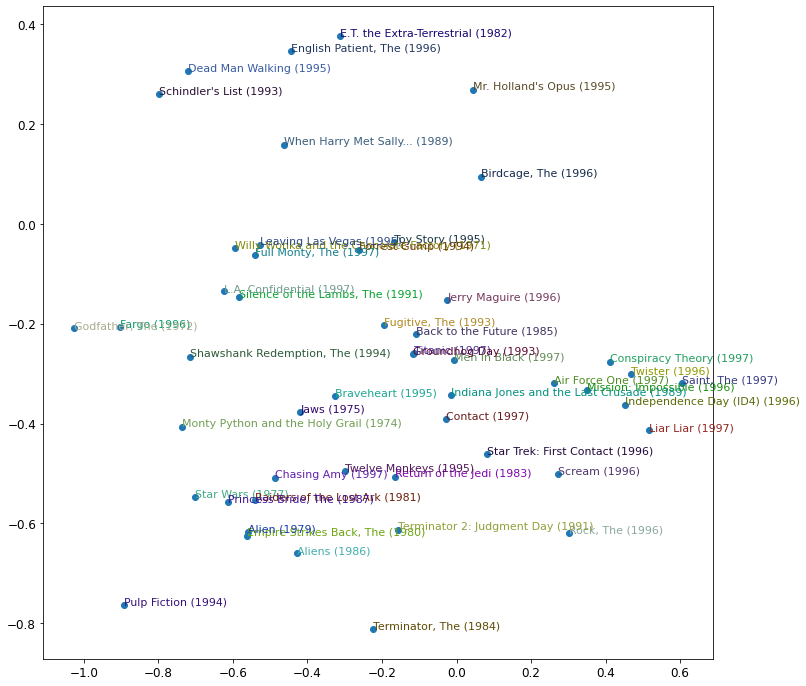

In [ ]:
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

Using fastai.collab

In [ ]:
# We can create and train a collaborative filtering model using the exact structure shown earlier by using fastai's collab_learner:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [ ]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.941033,0.957540,00:09
1,0.836400,0.873526,00:10
2,0.716883,0.833465,00:10
3,0.589564,0.820093,00:10
4,0.470875,0.820807,00:09


In [ ]:
# The names of the layers can be seen by printing the model: 
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [ ]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['L.A. Confidential (1997)',
 'Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 'Silence of the Lambs, The (1991)',
 'Rear Window (1954)']

Embedding Distance

In [ ]:
#If there were two movies that were nearly identical, then their embedding vectors would also have to be nearly identical
movie_factors = learn.model.i_weight.weight
movie_factors.shape

torch.Size([1665, 50])

In [ ]:
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']

In [ ]:
movie_factors[idx]

tensor([ 0.2485, -0.0107, -0.0868,  0.1826, -0.0288, -0.2008,  0.2116,  0.1169,  0.0824,  0.0568,  0.2978,  0.0190,  0.0554, -0.1837, -0.1990,  0.4339, -0.0717,  0.1563,  0.2516,  0.0266, -0.1500,
        -0.1704, -0.2149, -0.0834,  0.2258, -0.0270,  0.0991, -0.0468, -0.3276,  0.3497, -0.2079,  0.1690, -0.4486, -0.1395,  0.2426, -0.2360, -0.2470,  0.0057,  0.1793,  0.0286,  0.0287,  0.3763,
         0.2215, -0.1914, -0.1452,  0.1839, -0.2645, -0.0730, -0.0024, -0.1145], grad_fn=<SelectBackward0>)

In [ ]:
movie_factors[idx].shape

torch.Size([50])

In [ ]:
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx])
distances.shape

torch.Size([1665])

In [ ]:
idx = distances.argsort(descending=True)[0]
dls.classes['title'][idx]

'Silence of the Lambs, The (1991)'

In [ ]:
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'Wedding Gift, The (1994)'

Embedding Distance for Titanic

In [ ]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Titanic (1997)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx] #similar movie after Titanic itself

'In Love and War (1996)'

In [ ]:
dls.classes['title'][distances.argsort(descending=True)[0]] #the most similar movie is the same movie itself

'Titanic (1997)'

In [ ]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Titanic (1997)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1664]
dls.classes['title'][idx] #the most dissimilar movie in range 1664

'Ready to Wear (Pret-A-Porter) (1994)'

# Conclusion:
# User 13th predicted rating on Returning of Jedy is 5. Embedding distance for Titanic - the most similar movie is "In Love and War 1996", the most diddimilar mvie (the last in the tensor) is "Ready to wear 1994".